<a href="https://colab.research.google.com/github/netanelofer2/CCN_caiman_mesmerize_workshop_2023/blob/main/h01_data_access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install tensorstore to access the h01 volumetric data.
# You may need to restart the runtime after installing.
!pip install --upgrade numpy tensorstore

Requirement already up-to-date: numpy in /usr/local/lib/python3.7/dist-packages (1.20.3)
Requirement already up-to-date: tensorstore in /usr/local/lib/python3.7/dist-packages (0.1.11)


In [ ]:
import os
# Ensure tensorstore does not attempt to use GCE credentials
os.environ['GCE_METADATA_ROOT'] = 'metadata.google.internal.invalid'
import tensorstore as ts
import numpy as np
import matplotlib.pyplot as plt

Volumetric cutouts and point lookups for both the EM data and the segmentations can be performed using [TensorStore](https://github.com/google/tensorstore)

In [ ]:
context = ts.Context({'cache_pool': {'total_bytes_limit': 1000000000}})

In [ ]:
em_4nm = ts.open({
    'driver': 'neuroglancer_precomputed',
    'kvstore': {'driver': 'gcs', 'bucket': 'h01-release'},
    'path': 'data/20210601/4nm_raw'},
    read=True, context=context).result()[ts.d['channel'][0]]

In [ ]:
# Dimensions of img_cutout_4nm are [y, x]
img_cutout_4nm = em_4nm[320553*2:(320553+512)*2, 177054*2:(177054+512)*2, 3667].read().result().transpose()
img_cutout_4nm

array([[149, 173, 190, ...,  80, 216, 206],
       [146, 193, 156, ..., 155, 255, 157],
       [211, 206, 221, ...,  35, 107, 129],
       ...,
       [145, 223,  55, ..., 162, 162, 127],
       [ 66, 116,  29, ..., 140, 234, 230],
       [ 85,  92, 100, ..., 146, 215, 233]], dtype=uint8)

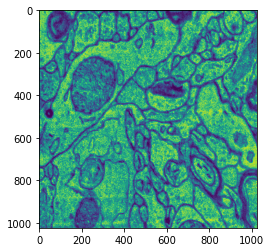

In [ ]:
plt.imshow(img_cutout_4nm)

In [ ]:
em_8nm = ts.open({
    'driver': 'neuroglancer_precomputed',
    'kvstore': {'driver': 'gcs', 'bucket': 'h01-release'},
    'path': 'data/20210601/4nm_raw',
    'scale_metadata': {'resolution': [8, 8, 33]}},
    read=True, context=context).result()[ts.d['channel'][0]]
c3_segmentation_8nm = ts.open({
    'driver': 'neuroglancer_precomputed',
    'kvstore': {'driver': 'gcs', 'bucket': 'h01-release'},
    'path': 'data/20210601/c3',
    'scale_metadata': {'resolution': [8, 8, 33]}},
    read=True, context=context).result()[ts.d['channel'][0]]

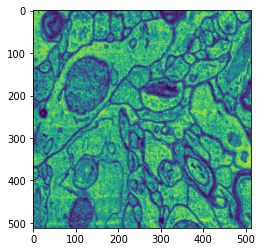

In [ ]:
# Dimensions of img_cutout_8nm are y, x
img_cutout_8nm = em_8nm[320553:320553+512, 177054:177054+512, 3667].read().result().transpose()

plt.imshow(img_cutout_8nm)

In [ ]:
# Dimensions of c3_cutout_8nm are y, x
c3_cutout_8nm = c3_segmentation_8nm[320553:320553+512, 177054:177054+512, 3667].read().result().transpose()
c3_cutout_8nm

array([[66666254407, 66666254407, 66666254407, ..., 66593423910,
        66593423910, 66593423910],
       [66666254407, 66666254407, 66666254407, ..., 66593423910,
        66593423910, 66593423910],
       [66666254407, 66666254407, 66666254407, ..., 66593423910,
        66593423910, 66593423910],
       ...,
       [66622597174, 66622597174, 66622597174, ..., 40303185592,
        40303185592, 40303185592],
       [66622597174, 66622597174, 66622597174, ..., 40303185592,
        40303185592, 40303185592],
       [66622597174, 66622597174, 66622597174, ..., 40303185592,
        40303185592, 40303185592]], dtype=uint64)

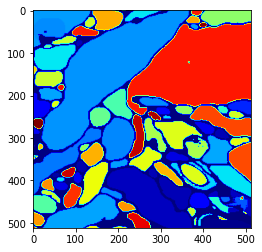

In [ ]:
def segid_hash(x, salt=1): return (x * salt * 2654435761) % 2**32
plt.imshow(segid_hash(c3_cutout_8nm.squeeze().transpose()), cmap=plt.cm.jet)

In [ ]:
# Tissue type classification volume
masking_64nm = ts.open({
    'driver': 'neuroglancer_precomputed',
    'kvstore': {'driver': 'gcs', 'bucket': 'h01-release'},
    'path': 'data/20210601/masking',
    'scale_metadata': {'resolution': [64, 64, 66]}},
    read=True, context=context).result()[ts.d['channel'][0]]

In [ ]:
# Dimensions of masking_cutout_64nm are y, x
masking_cutout_64nm = masking_64nm[320553//8:(320553+512)//8, 177054//8:(177054+512)//8, 3667//2].read().result().transpose()
masking_cutout_64nm

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 1]], dtype=uint64)

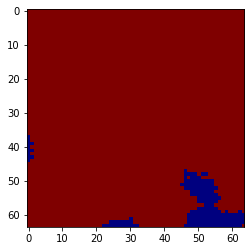

In [ ]:
plt.imshow(segid_hash(masking_cutout_64nm.squeeze().transpose()), cmap=plt.cm.jet)

Meshes and skeletons can be retrieved using the [Cloud-Volume](https://github.com/seung-lab/cloud-volume) library created by the Seung Lab.



In [ ]:
# Install cloud-volume to access h01 mesh and skeleton data.
# You may need to restart the runtime after installing.
!pip install cloud-volume

Cloud-Volume currently requires Google Account credentials to access data on GCS.  You will not be billed for data access, though.  To obtain Google Account credentials, evaluate the cell below.

In [ ]:
import cloudvolume
import google.colab.auth
google.colab.auth.authenticate_user()

In [ ]:
c3_cloudvolume = cloudvolume.CloudVolume('gs://h01-release/data/20210601/c3', progress=True)

In [ ]:
# Request the finest-resolution mesh for a single c3 segment id
mesh = c3_cloudvolume.mesh.get(3896803064)

In [ ]:
# Mesh vertices are in nanometers (not voxels)
list(mesh.values())[0].vertices

array([[2285208.  , 1298480.1 ,  135184.5 ],
       [2285192.  , 1298480.1 ,  135184.5 ],
       [2285184.  , 1298472.1 ,  135184.5 ],
       ...,
       [2623120.  , 1728136.1 ,   88885.57],
       [2623064.  , 1728080.1 ,   88885.57],
       [2622952.  , 1728040.1 ,   88935.07]], dtype=float32)

In [ ]:
# Request the skeleton for a single c3 segment id
skel = c3_cloudvolume.skeleton.get(3896803064)

Shard Indices: 1it [00:00,  6.39it/s]
Minishard Indices: 1it [00:00,  7.39it/s]
Decompressing: 100%|██████████| 1/1 [00:00<00:00, 161.66it/s]


In [ ]:
# Skeleton vertices are in nanometers (not voxels)
skel.vertices

array([[2598016., 1305120.,  142197.],
       [2598016., 1305440.,  142164.],
       [2598016., 1305728.,  142032.],
       ...,
       [2753472., 1292480.,   22539.],
       [2871872., 1193856.,   24255.],
       [2871808., 1193952.,   24255.]], dtype=float32)